In [40]:
install.packages("rlang")
library(tidyverse)
library(tidymodels)
library(dplyr)
library(ggplot2)


library(repr)

options(repr.matrix.max.rows = 6)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



## Data description

Players.csv 
Number of rows: 196 (each row represent a unique player)

Variables: 7

This dataset contains information on individual players
Variables and their issues:
- experience (character): Holds the players experience level (beginner, amateur, regular, pro, veteran). This variable should be mutated to a factor type, as there is a set amount of categorial options
- subscribe (logical): Represents whether the player has an active subscription by “TRUE” or “FALSE”. It must be converted to a factor to use for categorical analysis.
- hashedEmail (character):  It holds the hashed value of the user’s email to link the users playing session to themselves. A possible issue is its readability in visualizations. 
- played_hours (double): Total hours the player has played
- name (character): Holds the players display name, in-game.
- gender (character): Describes gender of each player. A potential issue is players who have selected prefer not to say
- age (double): The players age in years, continuous variable. An issue is N/A missing values.


In [47]:
player_data <- read_csv("players.csv")

players <- player_data|>
    mutate(Age = as.numeric(Age), played_hours = as.numeric(played_hours)) |>
    filter(!is.na(Age), !is.na(played_hours)) |>
    select(Age,played_hours)
players


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,played_hours
<dbl>,<dbl>
9,30.3
17,3.8
17,0.0
⋮,⋮
22,0.3
17,0.0
17,2.3


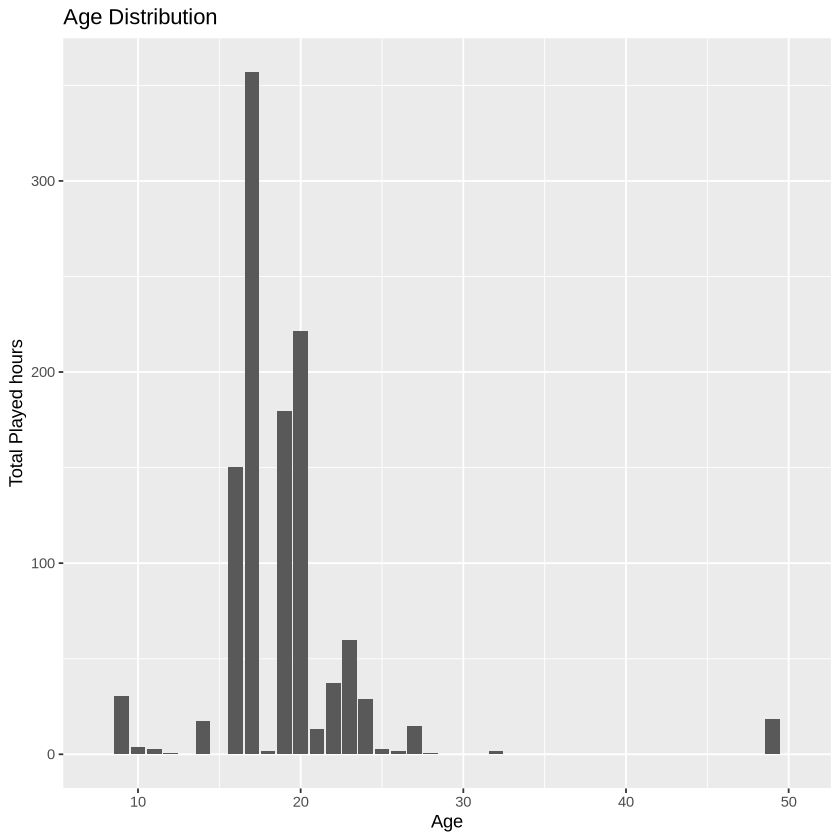

In [25]:
age_dist <- players |> ggplot(aes(x = Age, y = played_hours)) +
    geom_bar(stat = "identity") +
    labs(title = "Age Distribution",
       x = "Age",
       y = "Total Played hours")
age_dist

In [72]:
players_split <- initial_split(players, prop = .75, strata = Age)
players_training <- training(players_split)
players_testing <- testing(players_split)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

players_recipe <- recipe(played_hours ~ Age, data = players_training) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

players_vfold <- vfold_cv(players_training, v = 5, strata = Age)

players_workflow <- workflow() |>
    add_model(players_spec) |>
    add_recipe(players_recipe) |>
    fit(data = players_training)

grid_results <- tune_grid(
  players_workflow,
  resamples = players_vfold,
  grid = 10
)

best_k <- select_best(grid_results, "rmse")

players_workflow <- finalize_workflow(players_workflow, best_k) |>
  fit(data = players_training)

summary <- players_workflow |>
  predict(players_training) |>
  bind_cols(players_training) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')
summary


Warning message:
“tune samples were requested but there were 144 rows in the data. 139 will be used.”


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,25.78728


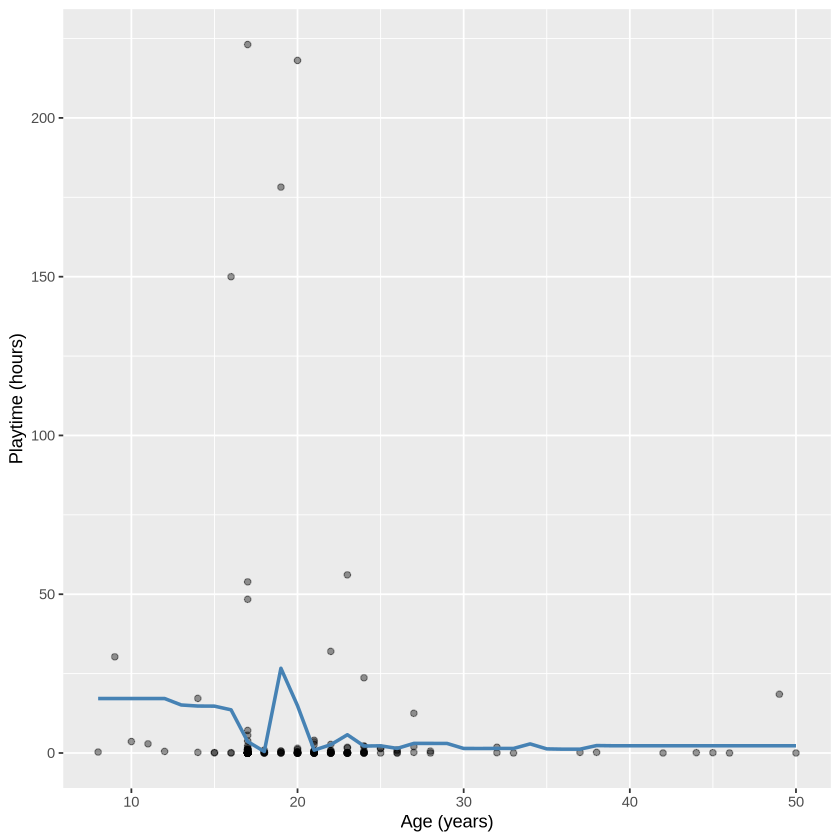

In [74]:
age_prediction_grid <- tibble(
    Age = seq(
        from = players |> select(Age) |> min(),
        to = players |> select(Age) |> max(),
        by = 1
    )
)

players_preds <- players_workflow |>
  predict(age_prediction_grid) |>
  bind_cols(age_prediction_grid)


plot_final <- ggplot(players, aes(x = Age, y = played_hours)) +
  geom_point(alpha = 0.4) +
  geom_line(data = players_preds,
            mapping = aes(x = Age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Age (years)") +
  ylab("Playtime (hours)")
  # scale_y_continuous(labels = dollar_format()) +
  # ggtitle(paste0("K = ", kmin)) +
  # theme(text = element_text(size = 12))

plot_final